In [1]:
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model,Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout, Input ,Activation,GlobalAveragePooling2D,InputLayer,MaxPool2D
from keras.optimizers import Adam
from PIL import Image
import tensorflow as tf
from keras.regularizers import l2
import matplotlib.pyplot as plt 
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import seaborn as sns
from sklearn.model_selection import train_test_split
import shutil
from keras.utils import Sequence
from sklearn.model_selection import train_test_split
from keras.activations import relu, softmax
tf.random.set_seed(34)

In [2]:
def create_dataframe(img_dir):
    file_paths = []
    labels = []
    for filename in os.listdir(img_dir):
        if filename.endswith('.jpg'):
            file_paths.append(os.path.join(img_dir, filename))
            label = 'cat' if filename.startswith('cat') else 'dog'
            labels.append(label)  

    return pd.DataFrame({'filename': file_paths, 'label': labels})

train_df = create_dataframe('/Users/buketcalp/Downloads/dogs-vs-cats/train')
valid_df = create_dataframe('/Users/buketcalp/Downloads/dogs-vs-cats/valid')
test_df = create_dataframe('/Users/buketcalp/Downloads/dogs-vs-cats/test')

In [3]:
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255)
valid_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='label',
    target_size=(224,224),
batch_size=BATCH_SIZE,
class_mode='binary'
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 20000 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


### Model 1

In [10]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                 

In [5]:
EPOCHS = 100

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    mode='min',
    restore_best_weights=True)


history = model.fit(
    train_generator,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=valid_generator,
    validation_steps=len(valid_df) // BATCH_SIZE,
    callbacks= early_stopping
)

Epoch 1/100


2024-01-28 12:16:46.332414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-01-28 12:16:46.440261: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


625/625 [==============================] - 396s 629ms/step - loss: 0.6890 - accuracy: 0.5271 - val_loss: 0.6760 - val_accuracy: 0.5701
Epoch 2/100
625/625 [==============================] - 388s 620ms/step - loss: 0.6755 - accuracy: 0.5734 - val_loss: 0.6572 - val_accuracy: 0.6042
Epoch 3/100
625/625 [==============================] - 388s 621ms/step - loss: 0.6393 - accuracy: 0.6241 - val_loss: 0.5938 - val_accuracy: 0.6791
Epoch 4/100
625/625 [==============================] - 403s 645ms/step - loss: 0.5882 - accuracy: 0.6802 - val_loss: 0.5507 - val_accuracy: 0.7264
Epoch 5/100
625/625 [==============================] - 390s 625ms/step - loss: 0.5555 - accuracy: 0.7123 - val_loss: 0.5250 - val_accuracy: 0.7480
Epoch 6/100
625/625 [==============================] - 408s 653ms/step - loss: 0.5255 - accuracy: 0.7418 - val_loss: 0.4882 - val_accuracy: 0.7624
Epoch 7/100
625/625 [==============================] - 379s 607ms/step - loss: 0.4917 - accuracy: 0.7663 - val_loss: 0.4646 - val_

### Model 1 Grafik

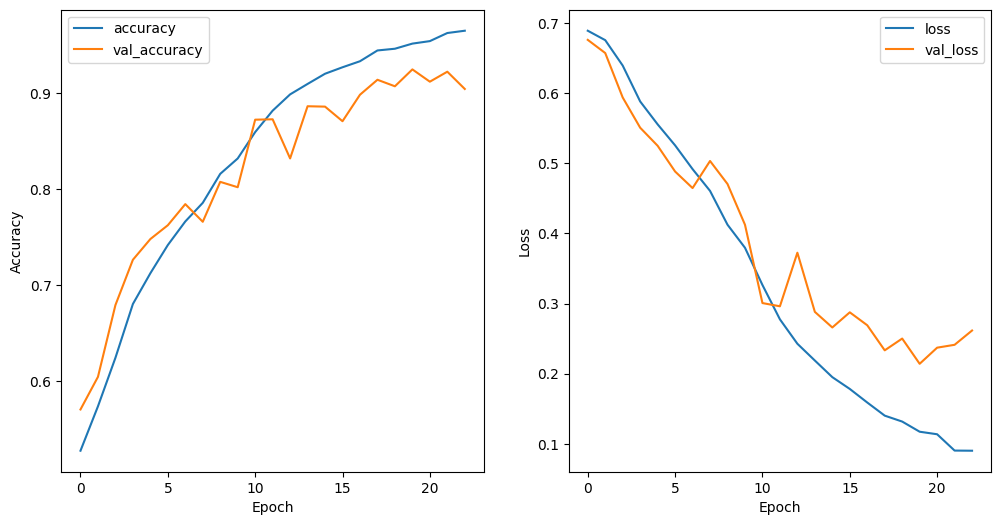

In [6]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Model 1 Confuison Matrix

In [7]:
class_indices = train_generator.class_indices
print(class_indices)

{'cat': 0, 'dog': 1}


In [8]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)

78/78 [==============================] - 15s 196ms/step - loss: 0.2233 - accuracy: 0.9223
Test Loss: 0.2232779711484909, Test Accuracy: 0.9222756624221802
78/78 [==============================] - 12s 152ms/step


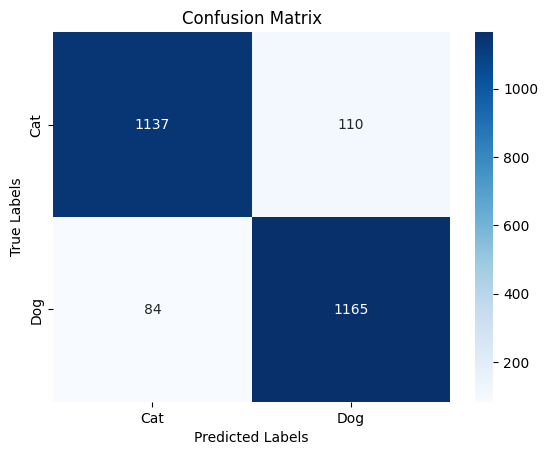

In [9]:
predicted_classes = np.where(predictions > 0.5, 1, 0).flatten() 
true_classes = test_generator.classes
true_classes = true_classes[:len(predicted_classes)]

conf_matrix = confusion_matrix(true_classes, predicted_classes)
ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['Cat', 'Dog'])
ax.yaxis.set_ticklabels(['Cat', 'Dog'])

plt.show()